# Task A: Designing a Convolution Module for Variable Input Channels

Design a special convolutional module that is spatial size invariant and can handle an arbitrary number of input channels. 

Explain:

1. design principles

2. references

3. additional costs (such as FLOPS or #PARAMS) 

and compare with naive models. 

## Needed packages and version

torchsummary

In [2]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

import torch
import torch.nn as nn       # module
import torch.optim as optim # optimizer

from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchvision import datasets, transforms

確認pytorch與cuda的版本

In [4]:
print("Pytorch version:",torch.__version__)
print("Cuda version:",torch.version.cuda)
print("cuDNN version:",torch.backends.cudnn.version())
print("Check if cuda is available:",torch.cuda.is_available())

Pytorch version: 2.6.0+cu126
Cuda version: 12.6
cuDNN version: 90501
Check if cuda is available: True


檢視訓練資料的類別

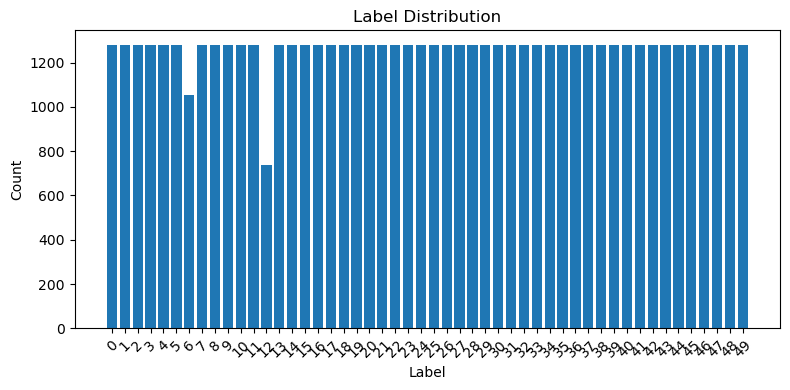

In [17]:
from collections import Counter
import matplotlib.pyplot as plt
with open(os.path.join(os.getcwd(),"images","train.txt")) as Name_file:
    lines = Name_file.readlines()
    lines = [line.replace("\n", "").split(" ") for line in lines]

targets = [line[1] for line in lines if len(line) > 1]
count_table = Counter(targets)

plt.figure(figsize=(8, 4))
plt.bar(count_table.keys(), count_table.values())
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

檢視資料的筆數

In [18]:
with open(os.path.join(os.getcwd(),"images","train.txt")) as Name_file:
    lines = Name_file.readlines()
    print("# train data:",len(lines))
with open(os.path.join(os.getcwd(),"images","test.txt")) as Name_file:
    lines = Name_file.readlines()
    print("# test data:",len(lines))
with open(os.path.join(os.getcwd(),"images","val.txt")) as Name_file:
    lines = Name_file.readlines()
    print("# validation data:",len(lines))

# train data: 63325
# test data: 450
# validation data: 450


## Self-designed convolution module

1. spatial size invariant

2. can handle an arbitrary number of input channels

Design a dynamic convolution module that can adjust its weights based on the number of input channels. This can be achieved by learning a weight-generating network that takes the input channels as an input and generates corresponding convolution kernels.

In [ ]:
class AdaptiveConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.

    def forward(self, x):
        return x

In [ ]:
class ImageClassDataset(Dataset):
    def __init__(self, names_file):
        self.images_dir = os.path.join(os.getcwd(), "images")
        self.x = []
        self.y = []
        
        with open(os.path.join(self.images_dir, names_file)) as Name_file:
            lines = Name_file.readlines()
            self.n_samples = len(lines)
            
            for line in lines:
                parts = line.strip().split(' ')
                self.x.append(parts[0])
                self.y.append(int(parts[1]))
    
    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.x[index])
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(self.y[index], dtype = torch.long)
        
        return image, label

    def __len__(self):
        return self.n_samples

## Base line model: VGG16

In [7]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        
        # Convolutional layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

檢查模型架構

In [11]:
from torchsummary import summary
myVGG16 = VGG16(50)
myVGG16.cuda()
summary(myVGG16, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Define Dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class MyDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = os.listdir(data_dir)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_paths[idx])
        image = Image.open(img_path)  # 加載圖片
        label = 0  # 假設每個圖片的標籤是 0

        if self.transform:
            image = self.transform(image)
        return image, label
    def __len__(self):
        return len(self.image_paths)

# 假設圖像處理的轉換（例如，轉換為張量）
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 創建自定義數據集實例
dataset = MyDataset(data_dir="path_to_images", transform=transform)

# 使用 DataLoader 加載數據
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# 訓練過程中使用 DataLoader
for images, labels in dataloader:
    print(images.shape, labels)


訓練的function

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, weight_decay=1e-5, patience=5, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_func=torch.nn.CrossEntropyLoss()

    # early stopping needed parameters
    best_val_loss = float('inf')
    early_stop_counter = 0
    # record the training process
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # 梯度初始化設為0
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = loss_func(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {val_accuracy:.4f}')
        
        # 早停检查
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            # 保存最佳模型
            torch.save(model.state_dict(), 'best_model.pth')
            print("保存最佳模型")
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"早停: {patience} 轮验证损失未改善")
                break

    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_losses, val_losses

In [ ]:




# === 2. 準備數據集 (以 CIFAR-10 為例) ===
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64  # 你可以調整 batch size
dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)

# 80% 訓練集，20% 驗證集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# === 3. 定義模型 (假設 myModel 是你設計的模型) ===
class myModel(nn.Module):
    def __init__(self, num_classes=10):
        super(myModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# === 4. 初始化模型，並使用 Data Parallel (多 GPU 訓練) ===
model = myModel().to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# === 5. 定義損失函數與 Adam 優化器 ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === 6. 設定 Early Stopping 來根據 Validation Loss 調整參數 ===
best_val_loss = float("inf")
patience = 5  # 若 5 個 epoch 沒有進步則停止
patience_counter = 0

# === 7. 訓練與驗證迴圈 ===
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # 訓練模式
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()  # 反向傳播
        optimizer.step()  # 更新參數

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss /= len(train_loader)

    # === 8. Validation (驗證模型) ===
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # 停止梯度計算，加速推理
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%\n")

    # === 9. Early Stopping (如果 Validation Loss 沒有改善，則停止訓練) ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 重置耐心計數器
        torch.save(model.state_dict(), "best_model.pth")  # 儲存最佳模型
        print("Best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# === 10. 加載最佳模型並進行推論 ===
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
print("Best model loaded for inference.")
